# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></div><div class="lev2 toc-item"><a href="#Input" data-toc-modified-id="Input-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input</a></div><div class="lev1 toc-item"><a href="#Read-population-age-data" data-toc-modified-id="Read-population-age-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read population age data</a></div><div class="lev2 toc-item"><a href="#We-also-load-and-process-the-NUTS3-data-for-broad-age-intervals" data-toc-modified-id="We-also-load-and-process-the-NUTS3-data-for-broad-age-intervals-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>We also load and process the NUTS3 data for broad age intervals</a></div><div class="lev1 toc-item"><a href="#Read-household-type-data" data-toc-modified-id="Read-household-type-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read household type data</a></div><div class="lev1 toc-item"><a href="#Read-family-per-type-and-size" data-toc-modified-id="Read-family-per-type-and-size-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Read family per type and size</a></div><div class="lev1 toc-item"><a href="#Read-family-status-per-age" data-toc-modified-id="Read-family-status-per-age-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Read family status per age</a></div><div class="lev2 toc-item"><a href="#Age-distribution" data-toc-modified-id="Age-distribution-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Age distribution</a></div><div class="lev3 toc-item"><a href="#Preparing-the-CDF-and-PDF" data-toc-modified-id="Preparing-the-CDF-and-PDF-511"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Preparing the CDF and PDF</a></div><div class="lev1 toc-item"><a href="#See-if-totals-are-comparable" data-toc-modified-id="See-if-totals-are-comparable-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>See if totals are comparable</a></div><div class="lev1 toc-item"><a href="#Syn-Pop-input-preparation" data-toc-modified-id="Syn-Pop-input-preparation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Syn Pop input preparation</a></div><div class="lev2 toc-item"><a href="#Age-distribtuion-of-population-per-sex" data-toc-modified-id="Age-distribtuion-of-population-per-sex-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Age distribtuion of population per sex</a></div><div class="lev2 toc-item"><a href="#The-cdf-on-the-household-type" data-toc-modified-id="The-cdf-on-the-household-type-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>The cdf on the household type</a></div><div class="lev2 toc-item"><a href="#The-CDF-on-the-size-of-each-household-type" data-toc-modified-id="The-CDF-on-the-size-of-each-household-type-73"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>The CDF on the size of each household type</a></div><div class="lev2 toc-item"><a href="#Save-the-dataframes-to-file" data-toc-modified-id="Save-the-dataframes-to-file-74"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Save the dataframes to file</a></div>

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Overview

In this notebook we show how to import and prepare the Eurostat data to pass them to the synthetic population generation featuring households.

What we are basically building is a set of four tables containing the following information:

- $P^{(NUTS)}(a|s)$ the age $a$ distribution for people living in a given $NUTS$ area given tehir sex $s$;
- $P^{(NUTS)}(h)$ the probability to have an household of kind $h$ for each $NUTS$ code;
- $P^{(NUTS)}(m|h)$ the probability, for each $NUTS$ code, for an household to have $m$ members given the household kind $h$;
- $P^{(NUTS)}(a|r,h)$ the probability, for each $NUTS$ code, for an household member to have age $a$ given that he is covering the role $r$ (i.e., parent/adult or children) in an household of kind $h$;

Later version will also account for schools, workplaces, commuting and will have a complete hierarchical description of the system.

## Input

Here we set the location of the input files (tables and tsv files from eurostat) and we set the global variables.

In [2]:
# The sex strings that will be found in the files
sexes = ["male", "female", "total"]

# The values of the ages to be simulated, extremes included!
ages = range(0, 101, 1)

# The excel file containing the population per sex and age for all the NUTS2
populationBySexAgeFile = "resources/Europe/population/structure/populationBySexAge_NUTS2_2011.xls"

# The tsv file containing the population totals per sex and age for the NUTS3 (we will use this to create the right amount of households)...
populationBySexAgeNUTS3file = "resources/Europe/population/structure/populationBySexBroadAge_NUTS3_1990-2016.tsv"

# The excel file containing the distribution of household kind per NUTS2
householdsTypeAllFile = "resources/Europe/population/structure/householdsTypeAll_NUTS2_2011.xls"

# The excel file containing the size distribution for each kind of household
familySizeDistributionFile="resources/Europe/population/structure/familiesAllTypeSize_NUTS2_2011.xls"

# The excel file containing the age distribution of the population per household type (i.e. which age have the components of households)...
populationPerHouseholdStatus="resources/Europe/population/structure/populationSexHouseholdAge_total_NUTS2_2011.xls"

Here we set the aggregations to be made among the household types.

Codes explained:
- `TOTAL`: total households;
- `FAM1`: households with one family nucleus:
    - `MAR`: households composed of married couple;
    - `REP`: households composed of couple in registered partnership;
    - `CSU`: households composed of couple in consesual union;
    - `M1_CH`: lone father with child(s);
    - `F1_CH`: lone mother with child(s);
- `FAM_GE2`: household with 2 or more family nucleus;
- `NFAM`: household composed of non-family nucleus:
    - `P1`: one-person household;
    - `MULTI`: multiperson household (e.g. students living together);
    
Every key is a household kind that we want to generate and the corresponding value is a list containing the columns that will be summed to give the total number of household in that group.

This aggregation will be used when computing the kind and size distribution of the household for each given NUTS.

Here we do not distinguish yet between the households with young childs (i.e., household where the oldest children has less than 25 years) and household with old children (i.e., household where at least one of the children is more than 25 years old).

Here we aggregate accordingly to:
- `CPL_NCH` couples with no children: all the couples either married `MAR_NCH`, in a registered relationship `REP_NCH` or consensual union `CSU_NCH` that have NO children;
- `CPL_WCH` couples with children: all the couples either married `MAR_{Y,O}CH`, in a registered relationship `REP_{Y,O}CH` or consensual union `CSU_{Y,O}CH` with children (either young or old);
- `M1_WCH` lone fathers with either young `M1_YCH` or old `M1_OCH` children;
- `F1_WCH` lone mothers with either young `F1_YCH` or old `F1_OCH` children;
- `A1_HH` singles counted in `P1`;
- `MULTI_HH` households that are not families with more than one adult (here we sum the multi-person households `MULTI` and the multi-nucleus families `FAM_GE2` since they are marginal).

In [3]:
houseHoldsAggregations = {\
        "CPL_NCH":  ["MAR_NCH", "REP_NCH", "CSU_NCH"],
        "CPL_WCH":  ["MAR_YCH", "REP_YCH", "CSU_YCH",
                     "MAR_OCH", "REP_OCH", "CSU_OCH"],
        "M1_CH":    ["M1_YCH", "M1_OCH"],
        "F1_CH":    ["F1_YCH", "F1_OCH"],
        "A1_HH":    ["P1"],
        "MULTI_HH": ["MULTI", "FAM_GE2"],
    }

From another table we will import the age distribution of people participating with different roles in different kind of household.
These are the grouping to aggregate the age distribution per household type:

- `NAP` + `UNK` sets the distribution for the adults living alone and/or in multiple person households (non families). These are mapped to `A1_HH` (one-adult or adults only households);
- `PAR1` accounts for the age distribution of parents in households with single parent (`{M,F}1_{Y,O}CH`) age distribution and saves it to `A1_XCH` (one adult with one or more children);
- `MAR` + `CSU` + `REP` sets the `CPL_{Y,O,N}CH` age distribution of adult parents composing a couple and living in an household with OR without children. This is saved to `CPL_XCH` (age of parents in a couple);
- `CH_PAR` sets the age distribution for the children found in household with either couples or lone parents;
- `TOTAL` sets the total age distribution of the population;

In [4]:
ageDistributionPerHouseholdAggregations = {\
                    "CPL_XCH": ["MAR", "CSU", "REP"],\
                    "A1_XCH":  ["PAR1"],\
                    "A1_HH":   ["NAP", "UNK"],\
                    "CH_PAR":  ["CH_PAR"],\
                    "TOTAL":   ["TOTAL"],\
               }

# Read population age data

Here we load the population age by sex, age and NUTS code 

In [6]:
dfs = {sex: pd.read_excel(populationBySexAgeFile, header=10, sheet_name=sex, index_col=0,)\
           for sex in sexes}
df = pd.concat(dfs, axis=1)
# Remove empty lines
df.fillna(value=.0, inplace=True)
df = df[df.sum(axis=1) > 0]
dfpopulationAge = df.copy(deep=True)
del df, dfs
dfpopulationAge.head(4)

female                                                        \
           TOTAL       Y0       Y1       Y2       Y3       Y4       Y5   
GEO/AGE                                                                  
BE       5598920  63694.0  63241.0  63440.0  62553.0  62400.0  60731.0   
BE1       582295   9024.0   8802.0   8327.0   7930.0   7733.0   7468.0   
BE10      582295   9024.0   8802.0   8327.0   7930.0   7733.0   7468.0   
BE2      3200462  34621.0  34129.0  34897.0  34378.0  34026.0  33018.0   

                                     ...      total                          \
              Y6       Y7       Y8   ...        Y91     Y92     Y93     Y94   
GEO/AGE                              ...                                      
BE       60017.0  58632.0  58087.0   ...    13187.0  7405.0  5758.0  4902.0   
BE1       7096.0   6698.0   6506.0   ...     1451.0   851.0   708.0   586.0   
BE10      7096.0   6698.0   6506.0   ...     1451.0   851.0   708.0   586.0   
BE2      32786.0  31753.0  31591.0   ...     7468.0  4241.0  3226.0  2823.0   

                                                         
            Y95     Y96     Y97     Y98     Y99    Y100  
GEO/AGE                                                  
BE       4358.0  3697.0  2534.0  1665.0  1138.0  1630.0  
BE1       499.0   492.0   298.0   227.0   152.0   237.0  
BE10      499.0   492.0   298.0   227.0   152.0   237.0  
BE2      2535.0  2044.0  1466.0   977.0   656.0   923.0  

[4 rows x 306 columns]

## We also load and process the NUTS3 data for broad age intervals

In [6]:
populationNUTS3 = pd.read_csv(populationBySexAgeNUTS3file, sep="\t", na_values=[":"])

tuplecol = populationNUTS3.columns[0]
for pos, label in enumerate(tuplecol.split(",")):
    label = label.split("\\")[0]
    populationNUTS3[label] = populationNUTS3[tuplecol].apply(lambda v:v.split(",")[pos])
del populationNUTS3[tuplecol]
del populationNUTS3["unit"]

populationNUTS3 = populationNUTS3.pivot_table(index=["geo"], columns=["sex", "age"], fill_value=.0)
populationNUTS3.head()

1990                                                           ...    \
sex       F                              M                            ...     
age   TOTAL UNK Y15-64 Y_GE65 Y_LT15 TOTAL UNK Y15-64 Y_GE65 Y_LT15   ...     
geo                                                                   ...     
AL        0   0      0      0      0     0   0      0      0      0   ...     
AL0       0   0      0      0      0     0   0      0      0      0   ...     
AL01      0   0      0      0      0     0   0      0      0      0   ...     
AL011     0   0      0      0      0     0   0      0      0      0   ...     
AL012     0   0      0      0      0     0   0      0      0      0   ...     

          2016                                                             \
sex          M                                     T                        
age      TOTAL UNK   Y15-64  Y_GE65  Y_LT15    TOTAL UNK   Y15-64  Y_GE65   
geo                                                                         
AL     1461326   0  1017251  178834  265241  2886026   0  2005138  371075   
AL0    1461326   0  1017251  178834  265241  2886026   0  2005138  371075   
AL01    431214   0        0       0       0   848059   0        0       0   
AL011    69644   0        0       0       0   134153   0        0       0   
AL012   141887   0        0       0       0   278775   0        0       0   

               
sex            
age    Y_LT15  
geo            
AL     509813  
AL0    509813  
AL01        0  
AL011       0  
AL012       0  

[5 rows x 405 columns]

# Read household type data
Here we load the data regarding the number of households for each household kind per NUTS code.

In [7]:
df = pd.read_excel(householdsTypeAllFile, header=10)
df = df.rename(columns={"GEO/HHCOMP": "NUTS"})
# Delete NUTS with zero data
df = df[df.sum(axis=1) > 1]
dfhouseholdType = df.set_index(["NUTS"])
del df
dfhouseholdType.head(4)

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,M1_CH,M1_YCH,M1_OCH,F1_CH,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI
NUTS,,,,,,,,,,,,,,,,,,,,,
BE,4727831,2986156.0,2041576.0,968546.0,938050.0,134980.0,131433.0,57354.0,73208.0,871.0,...,86370.0,65591.0,20779.0,385234.0,299431.0,85803.0,54871.0,1686804.0,1610298.0,76506.0
BE1,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,9558.0,7916.0,1642.0,53213.0,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0
BE10,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,9558.0,7916.0,1642.0,53213.0,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0
BE2,2658751,1780107.0,1286834.0,630811.0,569351.0,86672.0,74696.0,34121.0,40144.0,431.0,...,45382.0,33499.0,11883.0,175737.0,131600.0,44137.0,31280.0,847364.0,807101.0,40263.0


In [8]:
# See if someone misbehave for more than 0.5% for single + multiple people household = not-family households
dfhouseholdType[ ~ ((dfhouseholdType["P1"] + dfhouseholdType["MULTI"])/dfhouseholdType["NFAM"]).between(.995, 1.005) ]

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,M1_CH,M1_YCH,M1_OCH,F1_CH,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI
NUTS,,,,,,,,,,,,,,,,,,,,,


In [9]:
# See if someone misbehave for more than 0.5% for one-nucleus families + more than one nucleus families + not families = total
dfhouseholdType[ ~ ((dfhouseholdType["FAM1"] + dfhouseholdType["FAM_GE2"] + dfhouseholdType["NFAM"])/dfhouseholdType["TOTAL"]).between(.995, 1.005) ]

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,M1_CH,M1_YCH,M1_OCH,F1_CH,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI
NUTS,,,,,,,,,,,,,,,,,,,,,


In [10]:
# We keep the nuts2 levels only, i.e. the codes that have string length == 4, e.g., "ITC1".
dfhouseholdTypeCountry = dfhouseholdType[dfhouseholdType.index.str.len() == 4]
dfhouseholdTypeCountry.head()

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,M1_CH,M1_YCH,M1_OCH,F1_CH,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI
NUTS,,,,,,,,,,,,,,,,,,,,,
BE10,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,9558.0,7916.0,1642.0,53213.0,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0
BE21,754676,485321.0,347151.0,171844.0,153185.0,22122.0,21932.0,10115.0,11706.0,111.0,...,14147.0,10969.0,3178.0,51391.0,40133.0,11258.0,8449.0,260906.0,246382.0,14524.0
BE22,339414,241700.0,181502.0,83336.0,82366.0,15800.0,8480.0,4181.0,4230.0,69.0,...,6008.0,4042.0,1966.0,22500.0,15703.0,6797.0,6293.0,91421.0,86508.0,4913.0
BE23,615307,411017.0,289787.0,143162.0,128075.0,18550.0,18140.0,7997.0,10071.0,72.0,...,10118.0,7431.0,2687.0,40592.0,30428.0,10164.0,6787.0,197503.0,189270.0,8233.0
BE24,448142,305201.0,217184.0,102741.0,99036.0,15407.0,12416.0,5591.0,6744.0,81.0,...,7494.0,5473.0,2021.0,31917.0,23689.0,8228.0,5665.0,137276.0,130713.0,6563.0


In [11]:
# Aggregate the columns in the files to compute the probability distribution function per household type...
for aggname, aggcols in houseHoldsAggregations.items():
    dfhouseholdTypeCountry[aggname] = dfhouseholdTypeCountry[aggcols].sum(axis=1).div(dfhouseholdTypeCountry["TOTAL"]).copy(deep=True)
dfhouseholdTypeCountry.head()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI,MULTI_HH,CPL_WCH,A1_HH,CPL_NCH
NUTS,,,,,,,,,,,,,,,,,,,,,
BE10,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0,0.0357593,0.204617,0.492225,0.152122
BE21,754676,485321.0,347151.0,171844.0,153185.0,22122.0,21932.0,10115.0,11706.0,111.0,...,40133.0,11258.0,8449.0,260906.0,246382.0,14524.0,0.0304409,0.278749,0.326474,0.277494
BE22,339414,241700.0,181502.0,83336.0,82366.0,15800.0,8480.0,4181.0,4230.0,69.0,...,15703.0,6797.0,6293.0,91421.0,86508.0,4913.0,0.0330157,0.331436,0.254875,0.296682
BE23,615307,411017.0,289787.0,143162.0,128075.0,18550.0,18140.0,7997.0,10071.0,72.0,...,30428.0,10164.0,6787.0,197503.0,189270.0,8233.0,0.0244106,0.293668,0.307603,0.291905
BE24,448142,305201.0,217184.0,102741.0,99036.0,15407.0,12416.0,5591.0,6744.0,81.0,...,23689.0,8228.0,5665.0,137276.0,130713.0,6563.0,0.027286,0.310872,0.291678,0.282221


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

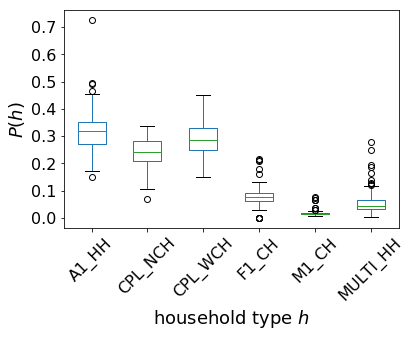

In [12]:
# The distribution of the household kind in the different countries
dfhouseholdTypeCountry[sorted(houseHoldsAggregations.keys())].plot(kind="box")

plt.xlabel(r"household type $h$", size=18)
plt.xticks(size=16, rotation= 45);

plt.ylabel(r"$P(h)$", size=18)
plt.yticks(size=16)

# Read family per type and size

Here we load a table that reports the number of households of a given size for each kind of household.
For instance we can have the number of households with a couple of parents and 3 childrens for each NUT 0, 1, and 2 level.

In [13]:
# The names of the sheets to load...
selectedSizes = ["TOTAL"] + ["%d" % s for s in range(2, 12)]

# Create one dataframe per hh size and remember that we renamed the GE11 to 11 (we assume no hh > 11 people)
df = {}
for size in selectedSizes:
    df[size] = pd.read_excel(familySizeDistributionFile, header=10, sheetname=size)
    df[size] = df[size].rename(columns={"GEO/HHCOMP": "NUTS"})
    df[size] = df[size].set_index(["NUTS"])

# Create the multindex [houseHoldType, houseHoldSize]
multindex = pd.MultiIndex.from_product([df.values()[0].columns, sorted(df.keys())])

# Merge in an ugly way the dataframes together
ddff = pd.DataFrame(data=0, index=df.values()[0].index, columns=multindex)
for size, sizeVals in df.iteritems():
    for kind in sizeVals.columns:
        ddff[kind, size] = sizeVals[kind]

# Delete empty rows
ddff = ddff[ddff.sum(axis=1) > 1]
        
# Now we can ask for dfFamilyTypeSize[kind, size]
dfFamilyTypeSize = ddff.copy(deep=True)
del df, ddff
dfFamilyTypeSize.head(4)

/usr/lib/python2.7/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


TOTAL                                                                  \
        10   11        2       3       4       5      6      7     8     9   
NUTS                                                                         
BE     494  340  1560945  692956  575246  196809  52376  13071  4076  1329   
BE1     86   47   126361   62131   47586   21091   7831   2439   737   217   
BE10    86   47   126361   62131   47586   21091   7831   2439   737   217   
BE2    263  220   947842  400219  348698  110605  26764   6281  2044   711   

       ...    F1_OCH                                                    \
       ...        11        2       3      4     5    6    7    8    9   
NUTS   ...                                                               
BE     ...       0.0  80333.0  7112.0  633.0  78.0  9.0  4.0  0.0  0.0   
BE1    ...       0.0   7904.0   749.0   81.0  14.0  1.0  0.0  0.0  0.0   
BE10   ...       0.0   7904.0   749.0   81.0  14.0  1.0  0.0  0.0  0.0   
BE2    ...       0.0  41291.0  3727.0  298.0  43.0  7.0  3.0  0.0  0.0   

               
        TOTAL  
NUTS           
BE    88169.0  
BE1    8749.0  
BE10   8749.0  
BE2   45369.0  

[4 rows x 209 columns]

# Read family status per age

Data from the 2011 census. Here we have the number of people of a given age and sex found in a given household kind and covering a giver role (e.g., lone parent, children in a family with couple of parents, parent in couple etc.).

In [7]:
# Read the sheet for each sex and then clean the dataframe later
dfs = {}
for sex in sexes:
    df = pd.read_excel(populationPerHouseholdStatus, sheetname=sex, header=[10,11], index_col=0)
    # Delete empty rows and save it 
    df.fillna(0, inplace=True)
    df = df[df.sum(axis=1, level=1) > 0]
    dfs[sex] = df
    del df
dfPopulationAgeHHstatus2011 = pd.concat(dfs, axis=1)
del dfs
dfPopulationAgeHHstatus2011.head(4)

/usr/local/lib/python2.7/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


female                                                    \
HHSTATUS      TOTAL                                                     
GEO/AGE       TOTAL   000-004   005-009   010-014   015-019   020-024   
BE        5598920.0  315328.0  296765.0  300722.0  317228.0  339446.0   
BE1        582295.0   41816.0   34233.0   30020.0   30059.0   40627.0   
BE10       582295.0   41816.0   34233.0   30020.0   30059.0   40627.0   
BE2       3200462.0  172051.0  161155.0  167276.0  179129.0  185169.0   

                                                   ...     total          \
HHSTATUS                                           ...       UNK           
GEO/AGE    025-029   030-034   035-039   040-044   ...   055-059 060-064   
BE        349328.0  358208.0  365389.0  388365.0   ...       0.0     0.0   
BE1        51401.0   51105.0   43747.0   39183.0   ...       0.0     0.0   
BE10       51401.0   51105.0   43747.0   39183.0   ...       0.0     0.0   
BE2       191737.0  198789.0  202451.0  225482.0   ...       0.0     0.0   

                                                                          
HHSTATUS                                                                  
GEO/AGE  065-069 070-074 075-079 080-084 085-089 090-094 095-099 100-101  
BE           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
BE1          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
BE10         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
BE2          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[4 rows x 594 columns]

In [15]:
# The Nan are in additional, useless areas...
print dfPopulationAgeHHstatus2011.shape
print dfPopulationAgeHHstatus2011.dropna(axis=0, how="any").index.symmetric_difference(dfPopulationAgeHHstatus2011.index)

(488, 594)
Index([u'ATZ', u'ATZZ', u'BEZ', u'BEZZ', u'BGZ', u'BGZZ', u'CH', u'CH0',
       u'CH01', u'CH02', u'CH03', u'CH04', u'CH05', u'CH06', u'CH07', u'CHZ',
       u'CHZZ', u'CYZ', u'CYZZ', u'CZZ', u'CZZZ', u'DEZ', u'DEZZ', u'DKZ',
       u'DKZZ', u'EEZ', u'EEZZ', u'ELS', u'ELSS', u'ELZ', u'ELZZ', u'ES53',
       u'ES63', u'ES64', u'ES7', u'ES70', u'ESZ', u'ESZZ', u'FIZ', u'FIZZ',
       u'FRZ', u'FRZZ', u'HRZ', u'HRZZ', u'HUZ', u'HUZZ', u'IEZ', u'IEZZ',
       u'ISZ', u'ISZZ', u'ITZ', u'ITZZ', u'LI', u'LI0', u'LI00', u'LIZ',
       u'LIZZ', u'LTZ', u'LTZZ', u'LUZ', u'LUZZ', u'LVZ', u'LVZZ', u'MTZ',
       u'MTZZ', u'NLZ', u'NLZZ', u'NOZ', u'NOZZ', u'PLZ', u'PLZZ', u'PTZ',
       u'PTZZ', u'ROZ', u'ROZZ', u'SEZ', u'SEZZ', u'SIZ', u'SIZZ', u'SKZ',
       u'SKZZ', u'UKZ', u'UKZZ'],
      dtype='object')


In [16]:
# So we drop them
dfPopulationAgeHHstatus2011.dropna(axis=0, how="any", inplace=True)

In [17]:
# Some are still missing...
dfPopulationAgeHHstatus2011.index.symmetric_difference(dfpopulationAge.index)

Index([u'CH', u'CH0', u'CH01', u'CH02', u'CH03', u'CH04', u'CH05', u'CH06',
       u'CH07', u'DEZ', u'DEZZ', u'ES53', u'ES63', u'ES64', u'ES7', u'ES70',
       u'LI', u'LI0', u'LI00', u'NOZ', u'NOZZ'],
      dtype='object')

## Age distribution

Plotting the age distribution for each kind of role (children, parent, adult) in each kind of household...

We create a new dataframe because we have to decompose the 5 years age blocks using the distribution of people for that age.

In particular, we multiply each 5 year block by the 5 years columns of that block divided by their sum for each NUTS code.

In [18]:
# Create the expected multindex
hhkinds = dfPopulationAgeHHstatus2011.columns.get_level_values(1).unique()
columnsAges = pd.MultiIndex.from_product(iterables=[sexes, hhkinds, ages], names=["sex", "hhkind", "age"])
dfAgesFixed = pd.DataFrame(columns=columnsAges)
dfAgesFixed.head()

Empty DataFrame
Columns: [(male, TOTAL, 0), (male, TOTAL, 1), (male, TOTAL, 2), (male, TOTAL, 3), (male, TOTAL, 4), (male, TOTAL, 5), (male, TOTAL, 6), (male, TOTAL, 7), (male, TOTAL, 8), (male, TOTAL, 9), (male, TOTAL, 10), (male, TOTAL, 11), (male, TOTAL, 12), (male, TOTAL, 13), (male, TOTAL, 14), (male, TOTAL, 15), (male, TOTAL, 16), (male, TOTAL, 17), (male, TOTAL, 18), (male, TOTAL, 19), (male, TOTAL, 20), (male, TOTAL, 21), (male, TOTAL, 22), (male, TOTAL, 23), (male, TOTAL, 24), (male, TOTAL, 25), (male, TOTAL, 26), (male, TOTAL, 27), (male, TOTAL, 28), (male, TOTAL, 29), (male, TOTAL, 30), (male, TOTAL, 31), (male, TOTAL, 32), (male, TOTAL, 33), (male, TOTAL, 34), (male, TOTAL, 35), (male, TOTAL, 36), (male, TOTAL, 37), (male, TOTAL, 38), (male, TOTAL, 39), (male, TOTAL, 40), (male, TOTAL, 41), (male, TOTAL, 42), (male, TOTAL, 43), (male, TOTAL, 44), (male, TOTAL, 45), (male, TOTAL, 46), (male, TOTAL, 47), (male, TOTAL, 48), (male, TOTAL, 49), (male, TOTAL, 50), (male, TOTAL, 51), (male, TOTAL, 52), (male, TOTAL, 53), (male, TOTAL, 54), (male, TOTAL, 55), (male, TOTAL, 56), (male, TOTAL, 57), (male, TOTAL, 58), (male, TOTAL, 59), (male, TOTAL, 60), (male, TOTAL, 61), (male, TOTAL, 62), (male, TOTAL, 63), (male, TOTAL, 64), (male, TOTAL, 65), (male, TOTAL, 66), (male, TOTAL, 67), (male, TOTAL, 68), (male, TOTAL, 69), (male, TOTAL, 70), (male, TOTAL, 71), (male, TOTAL, 72), (male, TOTAL, 73), (male, TOTAL, 74), (male, TOTAL, 75), (male, TOTAL, 76), (male, TOTAL, 77), (male, TOTAL, 78), (male, TOTAL, 79), (male, TOTAL, 80), (male, TOTAL, 81), (male, TOTAL, 82), (male, TOTAL, 83), (male, TOTAL, 84), (male, TOTAL, 85), (male, TOTAL, 86), (male, TOTAL, 87), (male, TOTAL, 88), (male, TOTAL, 89), (male, TOTAL, 90), (male, TOTAL, 91), (male, TOTAL, 92), (male, TOTAL, 93), (male, TOTAL, 94), (male, TOTAL, 95), (male, TOTAL, 96), (male, TOTAL, 97), (male, TOTAL, 98), (male, TOTAL, 99), ...]
Index: []

[0 rows x 2727 columns]

/usr/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


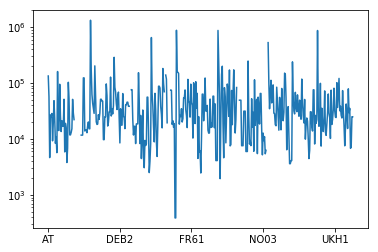

In [19]:
# Populate the new dataframe
for sex in ["male", "female", "total"]:
    for age in range(0, 101):
        for hhkind in hhkinds:
            ageIni = min(100, age - age%5)
            ageFin = min(101, ageIni + 4)
            
            rangeSTR = "%03d-%03d" % (ageIni, ageFin)
            popCol = "Y%d" % age
            popColumns = [(sex, "Y%d" % y) for y in range(ageIni, min(101, ageFin+1))] 
            
            # We decompose a single age group in 5 columns multiplying the original value by the
            # fraction of people with that age in that age range
            dfAgesFixed[sex, hhkind, age] =\
                        dfPopulationAgeHHstatus2011[sex, hhkind, rangeSTR].mul(\
                                dfpopulationAge[sex, popCol].div(\
                                                dfpopulationAge[popColumns].sum(axis=1).apply(lambda v: max(1.,v)), axis="index"),
                                            axis="index")
dfPopulationAgeHHstatus2011 = dfAgesFixed.copy(deep=True)
del dfAgesFixed
dfPopulationAgeHHstatus2011["total", "TOTAL", 50].plot()
plt.yscale("log")

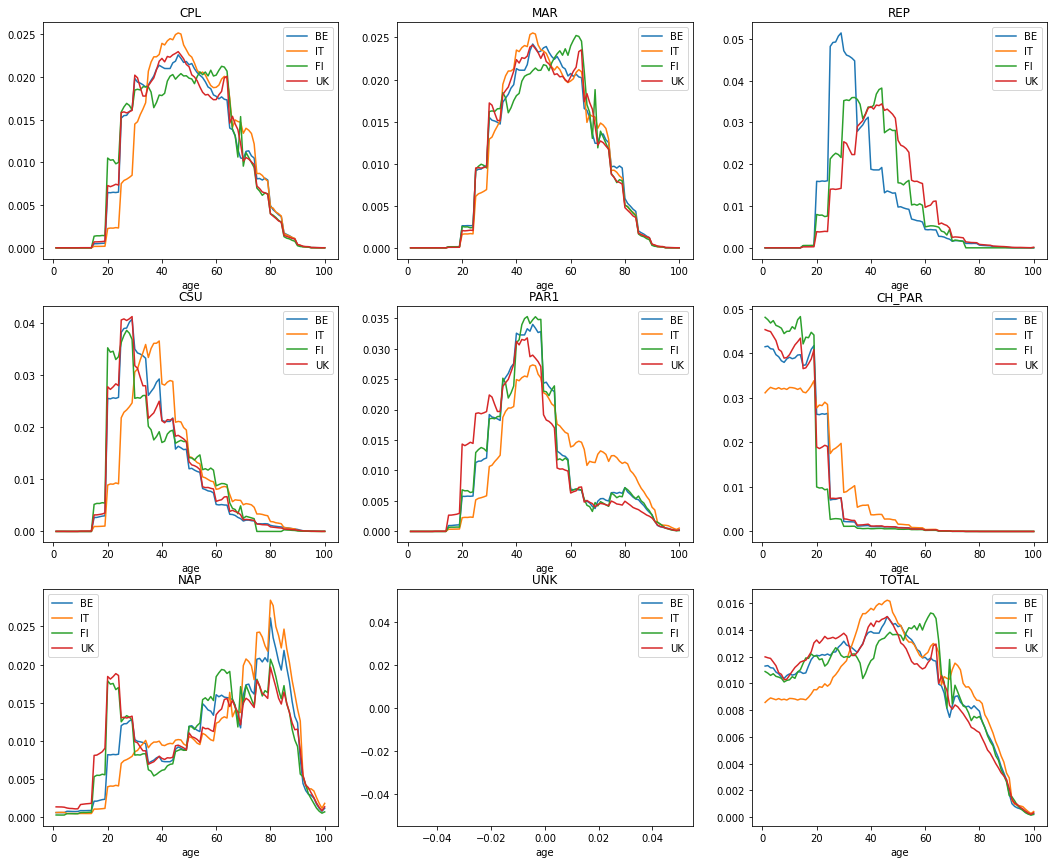

In [20]:
# Visually check that everything is working as expected
countries = ["BE", "IT", "FI", "UK"]
familyStatus = ["CPL", "MAR", "REP", "CSU", "PAR1", "CH_PAR", "NAP", "UNK", "TOTAL"]
sex = "female"

#################
#################

ncols = 3
nrows = 1 +  len(familyStatus) / ncols
plt.figure(figsize=(6*ncols, 5*nrows))
for iii, status in enumerate(familyStatus):
    plt.subplot(nrows, ncols, iii+1)
    plt.title(status)
    for country in countries:
        (dfPopulationAgeHHstatus2011[sex][status].loc[country][1:]\
                 .div(dfPopulationAgeHHstatus2011[sex][status].sum(axis=1).loc[country], axis="index")\
                ).plot(label=country)
    plt.legend()

### Preparing the CDF and PDF

We prepare the two pdf and cdf for each sex and hh group.

We also prepare the raw counter of people of each age group for each family status that will be passed to the household generator.


In [21]:
dfs_pdf, dfs_cdf, dfs_raw = {}, {}, {}
for aggKey, aggCols in ageDistributionPerHouseholdAggregations.iteritems():
    for sex in dfPopulationAgeHHstatus2011.columns.get_level_values(0).unique():
        tmp_df = dfPopulationAgeHHstatus2011[sex][aggCols].sum(axis=1, level=1)
        tmp_sum = tmp_df.sum(axis=1).copy()
        
        dfs_raw[(sex, aggKey)] = tmp_df.copy(deep=True)
        dfs_pdf[(sex, aggKey)] = tmp_df.div(tmp_sum, axis="index")
        dfs_cdf[(sex, aggKey)] = dfs_pdf[(sex, aggKey)].cumsum(axis=1)
        del tmp_df, tmp_sum

dfPopulationAgeHHstatus2011_PDF = pd.concat(dfs_pdf, axis=1)
dfPopulationAgeHHstatus2011_CDF = pd.concat(dfs_cdf, axis=1)
dfPopulationAgeHHstatus2011_RAW = pd.concat(dfs_raw, axis=1)
del dfs_pdf, dfs_cdf

/usr/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


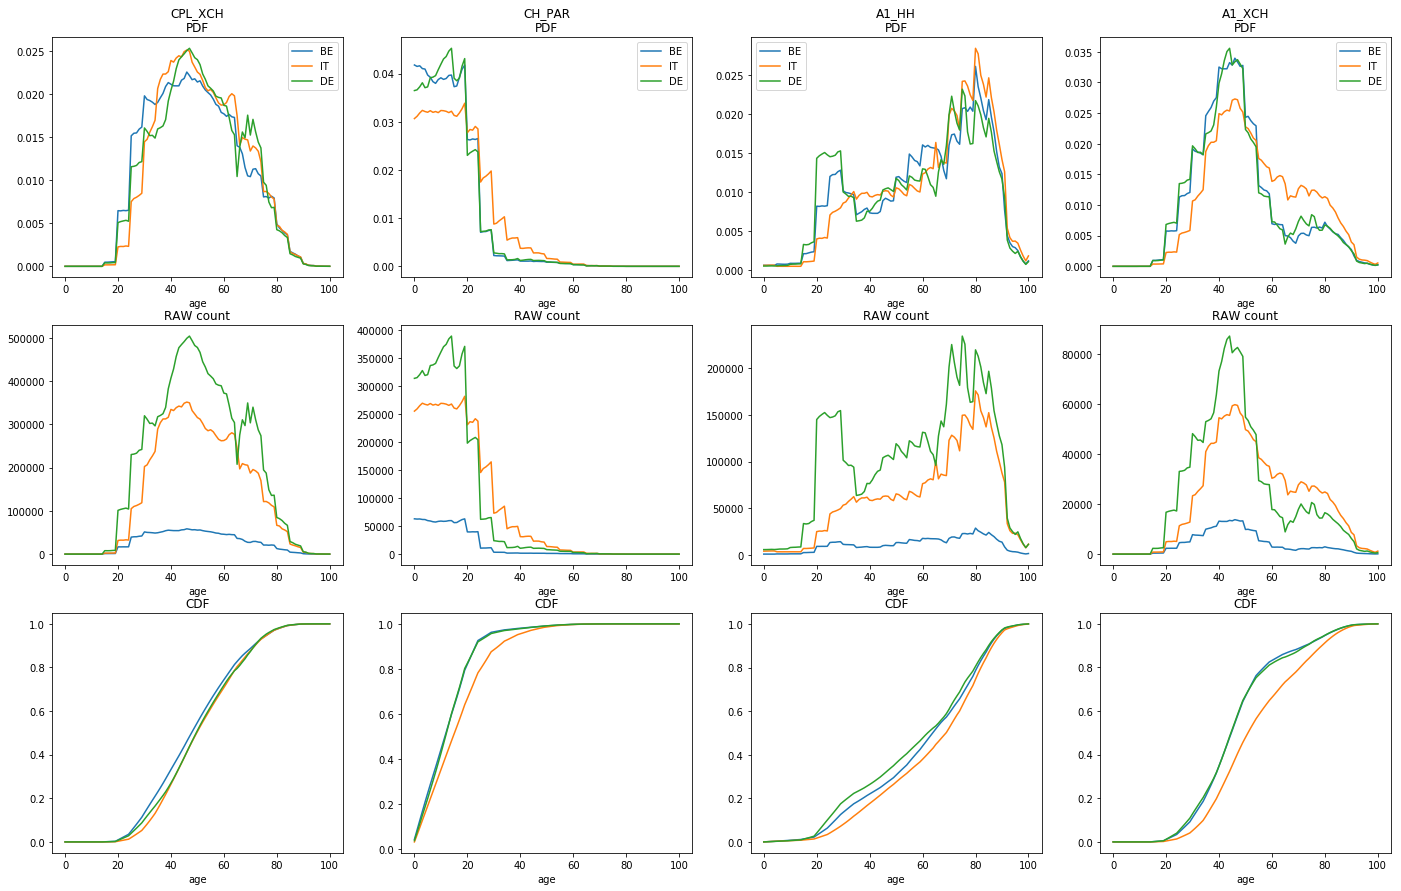

In [22]:
# Check visually that things are working...
countries = ["BE", "IT", "DE"]
familyStatus = ["CPL_XCH", "CH_PAR", "A1_HH", "A1_XCH"]
sex = "female"

##################
##################

ncols = len(familyStatus)
nrows = 3
plt.figure(figsize=(6*ncols, 5*nrows))

for iii, status in enumerate(familyStatus):
    for country in countries:
        # PDF
        plt.subplot(nrows, ncols, iii+1)
        plt.title(status + "\nPDF")
        dfPopulationAgeHHstatus2011_PDF[sex][status].loc[country].plot(label=country)
        plt.legend()
        
        # Raw count
        plt.subplot(nrows, ncols, iii+1+ncols)
        plt.title("RAW count")
        dfPopulationAgeHHstatus2011_RAW[sex][status].loc[country].plot(label=country)
        
        # CDF
        plt.subplot(nrows, ncols, iii+1+2*ncols)
        plt.title("CDF")
        dfPopulationAgeHHstatus2011_CDF[sex][status].loc[country].plot(label=country)

# See if totals are comparable

Here I simply check that the indexes in the `dfFamilyTypeSize` are the same of the `dfhouseholdType`.

In [23]:
problematic = dfFamilyTypeSize.loc[[i for i in dfFamilyTypeSize.index if len(i) < 5]].index.symmetric_difference(dfhouseholdType.index)

In [24]:
problematic

Index([u'FI', u'HR', u'HR0', u'HR03', u'HR04', u'NOZ'], dtype='object', name=u'NUTS')

Now, among these problematic NUTS we have:
- `FI` is troublesome and we delete it all;
- `HR` is a problem also for the Ajelli paper so we delete it;
- `IS` is empty and we delete it;
- `NOZ` is very little and we delete it;

In [25]:
selectedProblematicRoots = ["FI", "HR", "IS", "NOZ"]
for problematicRoot in selectedProblematicRoots:
    dfFamilyTypeSize = dfFamilyTypeSize[ ~dfFamilyTypeSize.index.str.startswith(problematicRoot)]
    dfhouseholdType = dfhouseholdType[ ~dfhouseholdType.index.str.startswith(problematicRoot)]

In [26]:
# Check that we have all the codes in both...
dfFamilyTypeSize[dfFamilyTypeSize.index.str.len() < 5].index.symmetric_difference(dfhouseholdType.index)

Index([], dtype='object', name=u'NUTS')

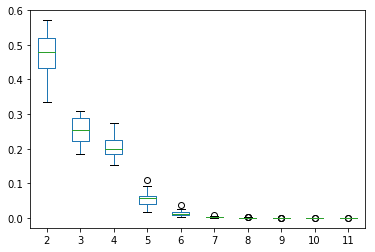

In [27]:
# Check the household size distribution over all the countries...
dfFamilyTypeSizeCountry = dfFamilyTypeSize[dfFamilyTypeSize.index.str.len() == 2]["TOTAL"].copy()
dfFamilyTypeSizeCountry = dfFamilyTypeSizeCountry.div(dfFamilyTypeSizeCountry["TOTAL"], axis="index")
dfFamilyTypeSizeCountry[["%d" % s for s in range(2, 12)]].plot(kind="box")

# Syn Pop input preparation

We already have the $P^{(NUTS)}(a\,|\,h,r)$ and the corresponding $PDF$ and $CDF$ of the age $a$ distribution per role $r$ covered in household of type $h$.

To generate the households we also need:

- the $P^{(NUTS)}(a\,|\,s)$ and $CDF$ of the age distribution by sex and NUTS code;
- the $P^{(NUTS)}(h)$ and $CDF$ of the household type $h$ for each NUTS; 
- the $P^{(NUTS)}(m\,|\,h)$ and $CDF$ of the number of members $m$ (size) of an household given the household's type $h$, for each NUTS;

In this way we can apply the following algorithm:
- select an household type $h$ from $P^{(NUTS)}(h)$;
- select the household size $m$ from $P^{(NUTS)}(m\,|\,h)$;
- depending on the household kind $h$, for each role $r$ select the age $a$ of the components from the $P^{(NUTS)}(a\,|\,h,r)$ distribution.


## Age distribtuion of population per sex

In [28]:
dfpopulationAge.head(4)

female                                                        \
           TOTAL       Y0       Y1       Y2       Y3       Y4       Y5   
GEO/AGE                                                                  
BE       5598920  63694.0  63241.0  63440.0  62553.0  62400.0  60731.0   
BE1       582295   9024.0   8802.0   8327.0   7930.0   7733.0   7468.0   
BE10      582295   9024.0   8802.0   8327.0   7930.0   7733.0   7468.0   
BE2      3200462  34621.0  34129.0  34897.0  34378.0  34026.0  33018.0   

                                     ...      total                          \
              Y6       Y7       Y8   ...        Y91     Y92     Y93     Y94   
GEO/AGE                              ...                                      
BE       60017.0  58632.0  58087.0   ...    13187.0  7405.0  5758.0  4902.0   
BE1       7096.0   6698.0   6506.0   ...     1451.0   851.0   708.0   586.0   
BE10      7096.0   6698.0   6506.0   ...     1451.0   851.0   708.0   586.0   
BE2      32786.0  31753.0  31591.0   ...     7468.0  4241.0  3226.0  2823.0   

                                                         
            Y95     Y96     Y97     Y98     Y99    Y100  
GEO/AGE                                                  
BE       4358.0  3697.0  2534.0  1665.0  1138.0  1630.0  
BE1       499.0   492.0   298.0   227.0   152.0   237.0  
BE10      499.0   492.0   298.0   227.0   152.0   237.0  
BE2      2535.0  2044.0  1466.0   977.0   656.0   923.0  

[4 rows x 306 columns]

In [29]:
sexAgeCDF = {}
sexAgePDF = {}
ageCols = ["Y%d" % d for d in range(0,101)]
for sex in dfpopulationAge.columns.get_level_values(0).unique():
    # Fetch out the columns with the age and rename columns to integers!
    tmp_df = dfpopulationAge[[(sex,col) for col in ageCols]][sex]
    tmp_df.rename({k: int(k[1:]) for k in tmp_df.columns}, axis="columns", inplace=True)
    tmp_sum = tmp_df.sum(axis=1) # Compute the sum
    sexAgePDF[sex] = tmp_df.div(tmp_sum, axis="index") # Divide with the key of the NUTS
    
    tmp_df = tmp_df.cumsum(axis=1) # Make the cumulative
    tmp_df = tmp_df.div(tmp_sum, axis="index")
    sexAgeCDF[sex] = tmp_df
    
    #del tmp_df, tmp_sum
    
# Make sexAgeCDF and PDF dataframes great again...
# We concat them given the sex, unstack the nested index,
# swap the columns and aggregate again the sex
sexAgeCDF = pd.concat(sexAgeCDF).unstack(0)
sexAgeCDF.columns = sexAgeCDF.columns.swaplevel(0,1)
sexAgeCDF.sort_index(level=0, axis=1, inplace=True)

sexAgePDF = pd.concat(sexAgePDF).unstack(0)
sexAgePDF.columns = sexAgePDF.columns.swaplevel(0,1)
sexAgePDF.sort_index(level=0, axis=1, inplace=True)

## The cdf on the household type

As specified in the `houseHoldsAggregations` variable we will select 6 kind of households:
- `CPL_NCH` a couple with no children = sum `{MAR,REP,CSU}_NCH`;
- `CPL_WCH` a couple with children (either young or old) = sum `{MAR,REP, CSU}_{Y,O}CH`;
- `M1_CH` lone father with children (either young or old as above) = sum `M1_{Y,O}CH`;
- `F1_CH` lone mother with children (either young or old as above) = sum `M1_{Y,O}CH`;
- `A1_HH` lone adult, no children (singles);
- `MULTI_HH` household made of several people, same size distribution as the overall for the others (by now we include here the multifamilies) = sum `MULTI`, `FAM_GE2`;

In [30]:
houseHoldsAggregations

{'A1_HH': ['P1'],
 'CPL_NCH': ['MAR_NCH', 'REP_NCH', 'CSU_NCH'],
 'CPL_WCH': ['MAR_YCH', 'REP_YCH', 'CSU_YCH', 'MAR_OCH', 'REP_OCH', 'CSU_OCH'],
 'F1_CH': ['F1_YCH', 'F1_OCH'],
 'M1_CH': ['M1_YCH', 'M1_OCH'],
 'MULTI_HH': ['MULTI', 'FAM_GE2']}

In [31]:
dfhouseholdType.head(n=2)

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,M1_CH,M1_YCH,M1_OCH,F1_CH,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI
NUTS,,,,,,,,,,,,,,,,,,,,,
BE,4727831,2986156.0,2041576.0,968546.0,938050.0,134980.0,131433.0,57354.0,73208.0,871.0,...,86370.0,65591.0,20779.0,385234.0,299431.0,85803.0,54871.0,1686804.0,1610298.0,76506.0
BE1,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,9558.0,7916.0,1642.0,53213.0,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0


In [32]:
for aggregationName, aggregationColumns in houseHoldsAggregations.iteritems():
    dfhouseholdType[aggregationName] = dfhouseholdType[aggregationColumns].sum(axis=1)
dfhouseholdType.head(n=2)

,TOTAL,FAM1,MAR,MAR_NCH,MAR_YCH,MAR_OCH,REP,REP_NCH,REP_YCH,REP_OCH,...,F1_YCH,F1_OCH,FAM_GE2,NFAM,P1,MULTI,MULTI_HH,CPL_WCH,A1_HH,CPL_NCH
NUTS,,,,,,,,,,,,,,,,,,,,,
BE,4727831,2986156.0,2041576.0,968546.0,938050.0,134980.0,131433.0,57354.0,73208.0,871.0,...,299431.0,85803.0,54871.0,1686804.0,1610298.0,76506.0,131377.0,1311083.0,1610298.0,1203469.0
BE1,544529,257026.0,159209.0,62829.0,88934.0,7446.0,9628.0,4747.0,4829.0,52.0,...,44696.0,8517.0,5600.0,281903.0,268031.0,13872.0,19472.0,111420.0,268031.0,82835.0


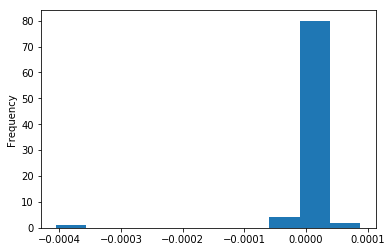

In [33]:
# Check that the sum of my household match with the total
newTotal = dfhouseholdType[houseHoldsAggregations.keys()].sum(axis=1)

# The histogram of the percentual difference shoes very limited values (~0.04% of total household maximim)
dfhouseholdType.sub(newTotal, axis="index").div(dfhouseholdType["TOTAL"], axis="index")[newTotal != dfhouseholdType["TOTAL"]]["TOTAL"].plot.hist()

In [34]:
# Calculating the PDf and the CDF for the household type
# household type is sorted accordingly to the order of the `houseHoldsAggregations` keys...
dfhouseholdTypePDF = dfhouseholdType[houseHoldsAggregations.keys()].copy(deep=True)
dfhouseholdTypePDFSUM = dfhouseholdTypePDF.sum(axis=1)
dfhouseholdTypePDF = dfhouseholdTypePDF.div(dfhouseholdTypePDFSUM, axis="index")
del dfhouseholdTypePDFSUM

dfhouseholdTypeCDF = dfhouseholdTypePDF.copy(deep=True).cumsum(axis=1)
dfhouseholdTypeCDF.head(4)

,MULTI_HH,CPL_WCH,F1_CH,M1_CH,A1_HH,CPL_NCH
NUTS,,,,,,
BE,0.027788,0.305100,0.386582,0.404850,0.745450,1.0
BE1,0.035759,0.240377,0.338100,0.355652,0.847878,1.0
BE10,0.035759,0.240377,0.338100,0.355652,0.847878,1.0
BE2,0.026908,0.323065,0.389162,0.406231,0.709795,1.0


In [35]:
dfhouseholdTypePDF.head(4)

,MULTI_HH,CPL_WCH,F1_CH,M1_CH,A1_HH,CPL_NCH
NUTS,,,,,,
BE,0.027788,0.277312,0.081482,0.018268,0.340600,0.254550
BE1,0.035759,0.204617,0.097723,0.017553,0.492225,0.152122
BE10,0.035759,0.204617,0.097723,0.017553,0.492225,0.152122
BE2,0.026908,0.296156,0.066098,0.017069,0.303564,0.290205


## The CDF on the size of each household type

In [36]:
dfFamilyTypeSize.head(4)

TOTAL                                                                  \
        10   11        2       3       4       5      6      7     8     9   
NUTS                                                                         
BE     494  340  1560945  692956  575246  196809  52376  13071  4076  1329   
BE1     86   47   126361   62131   47586   21091   7831   2439   737   217   
BE10    86   47   126361   62131   47586   21091   7831   2439   737   217   
BE2    263  220   947842  400219  348698  110605  26764   6281  2044   711   

       ...    F1_OCH                                                    \
       ...        11        2       3      4     5    6    7    8    9   
NUTS   ...                                                               
BE     ...       0.0  80333.0  7112.0  633.0  78.0  9.0  4.0  0.0  0.0   
BE1    ...       0.0   7904.0   749.0   81.0  14.0  1.0  0.0  0.0  0.0   
BE10   ...       0.0   7904.0   749.0   81.0  14.0  1.0  0.0  0.0  0.0   
BE2    ...       0.0  41291.0  3727.0  298.0  43.0  7.0  3.0  0.0  0.0   

               
        TOTAL  
NUTS           
BE    88169.0  
BE1    8749.0  
BE10   8749.0  
BE2   45369.0  

[4 rows x 209 columns]

In [37]:
# CDF & PDF
# Here we have to build the probability density, and cumulative density functions starting from the data.

dfs_cdf = {k: dfFamilyTypeSize[l].sum(axis=1, level=1) for k, l in houseHoldsAggregations.items() if k not in ["A1_HH", "MULTI_HH"]}
dfs_pdf = {k: dfFamilyTypeSize[l].sum(axis=1, level=1) for k, l in houseHoldsAggregations.items() if k not in ["A1_HH", "MULTI_HH"]}

# Adding the size 1 column to zeros and renaming...
for dk in dfs_cdf.keys():
    dfs_cdf[dk]["1"] = np.zeros(dfs_cdf[dk].shape[0])
    dfs_pdf[dk]["1"] = np.zeros(dfs_pdf[dk].shape[0])
    
    dfs_cdf[dk].rename(columns={k: int(k) if k!= "TOTAL" else k for k in dfs_cdf[dk].columns}, inplace=True)
    dfs_pdf[dk].rename(columns={k: int(k) if k!= "TOTAL" else k for k in dfs_pdf[dk].columns}, inplace=True)
    
    dfs_cdf[dk] = dfs_cdf[dk][sorted(dfs_cdf[dk].columns)].div(dfs_cdf[dk]["TOTAL"], axis="index")
    dfs_pdf[dk] = dfs_cdf[dk][sorted(dfs_cdf[dk].columns)].div(dfs_cdf[dk]["TOTAL"], axis="index")
    
    del dfs_cdf[dk]["TOTAL"]
    del dfs_pdf[dk]["TOTAL"]
    
    dfs_cdf[dk] = dfs_cdf[dk].cumsum(axis=1)
    
# Doing the trivial ones
dfs_cdf["A1_HH"] = dfs_cdf[dk].copy(deep=True)
dfs_pdf["A1_HH"] = dfs_pdf[dk].copy(deep=True)

dfs_cdf["A1_HH"].loc[:] = np.zeros(dfs_cdf["A1_HH"].shape)
dfs_pdf["A1_HH"].loc[:] = np.zeros(dfs_pdf["A1_HH"].shape)

dfs_cdf["A1_HH"][1] = 1.
dfs_pdf["A1_HH"][1] = 1.

# The multi has the same size distribution of the overall case
tmp_df = dfFamilyTypeSize["TOTAL"].copy(deep=True)
tmp_total = tmp_df["TOTAL"].copy()

del tmp_df["TOTAL"]

tmp_df.rename(columns={k: int(k) for k in tmp_df.columns}, inplace=True)
tmp_df[1] = np.zeros(tmp_df.shape[0])
tmp_df = tmp_df[sorted(tmp_df.columns)]

dfs_cdf["MULTI_HH"] = tmp_df.cumsum(axis=1)
dfs_cdf["MULTI_HH"] = dfs_cdf["MULTI_HH"].div(tmp_total, axis="index")

dfs_pdf["MULTI_HH"] = tmp_df.copy(deep=True)
dfs_pdf["MULTI_HH"] = dfs_pdf["MULTI_HH"].div(tmp_total, axis="index")


dfsHouseHoldType_sizeCDF = dfs_cdf
dfsHouseHoldType_sizePDF = dfs_pdf
del dfs_cdf, dfs_pdf, tmp_df, tmp_total

# Make the dfsHouseHoldType_size{P,C}DF dataframes great again...
dfsHouseHoldType_sizeCDF = pd.concat(dfsHouseHoldType_sizeCDF).unstack(0)
dfsHouseHoldType_sizeCDF.columns = dfsHouseHoldType_sizeCDF.columns.swaplevel(0,1)
dfsHouseHoldType_sizeCDF.sort_index(level=0, axis=1, inplace=True)

dfsHouseHoldType_sizePDF = pd.concat(dfsHouseHoldType_sizePDF).unstack(0)
dfsHouseHoldType_sizePDF.columns = dfsHouseHoldType_sizePDF.columns.swaplevel(0,1)
dfsHouseHoldType_sizePDF.sort_index(level=0, axis=1, inplace=True)

In [38]:
dfsHouseHoldType_sizeCDF.head(4)

A1_HH                            ...  MULTI_HH                      \
        1  2  3  4  5  6  7  8  9  10 ...        2         3         4    
NUTS                                  ...                                 
BE       1  0  0  0  0  0  0  0  0  0 ...  0.503914  0.727618  0.913323   
BE1      1  0  0  0  0  0  0  0  0  0 ...  0.470573  0.701951  0.879163   
BE10     1  0  0  0  0  0  0  0  0  0 ...  0.470573  0.701951  0.879163   
BE2      1  0  0  0  0  0  0  0  0  0 ...  0.514113  0.731193  0.920327   

                                                                     
            5         6         7         8         9         10 11  
NUTS                                                                 
BE    0.976858  0.993766  0.997986  0.999302  0.999731   0.99989  1  
BE1   0.957706  0.986869  0.995952  0.998697  0.999505  0.999825  1  
BE10  0.957706  0.986869  0.995952  0.998697  0.999505  0.999825  1  
BE2    0.98032  0.994837  0.998244  0.999352  0.999738  0.999881  1  

[4 rows x 66 columns]

In [39]:
dfsHouseHoldType_sizePDF.head(4)

A1_HH                                ...       MULTI_HH            \
        1  2  3  4  5  6  7  8  9  10     ...             2         3    
NUTS                                      ...                            
BE       1  0  0  0  0  0  0  0  0  0     ...       0.503914  0.223704   
BE1      1  0  0  0  0  0  0  0  0  0     ...       0.470573  0.231378   
BE10     1  0  0  0  0  0  0  0  0  0     ...       0.470573  0.231378   
BE2      1  0  0  0  0  0  0  0  0  0     ...       0.514113   0.21708   

                                                                           \
            4          5          6           7           8            9    
NUTS                                                                        
BE    0.185704  0.0635351  0.0169083  0.00421966  0.00131584  0.000429036   
BE1   0.177212  0.0785436  0.0291629  0.00908292  0.00274461  0.000808115   
BE10  0.177212  0.0785436  0.0291629  0.00908292  0.00274461  0.000808115   
BE2   0.189135  0.0599925  0.0145169  0.00340683  0.00110867  0.000385649   

                                
               10           11  
NUTS                            
BE    0.000159476  0.000109761  
BE1   0.000320267   0.00017503  
BE10  0.000320267   0.00017503  
BE2   0.000142652  0.000119329  

[4 rows x 66 columns]

## Save the dataframes to file

In [40]:
# The raw counts, pdf and cdf for the age given hh status...
dfPopulationAgeHHstatus2011_RAW.to_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_RAW.pkl")
dfPopulationAgeHHstatus2011_PDF.to_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_PDF.pkl")
dfPopulationAgeHHstatus2011_CDF.to_pickle("resources/Europe/population/structure/dataframes/2011_ageByHHstatus_CDF.pkl")

In [41]:
# The population age distribution by sex (will be used as a reference) both for the NUTS2 and 3 (this one with broad age groups)
sexAgeCDF.to_pickle("resources/Europe/population/structure/dataframes/2011_ageBySex_CDF.pkl")
sexAgePDF.to_pickle("resources/Europe/population/structure/dataframes/2011_ageBySex_PDF.pkl")

populationNUTS3.to_pickle("resources/Europe/population/structure/dataframes/1990-2016_broadAgeBySexNUTS3.pkl")

In [42]:
# The household type CDF and PDF...
dfhouseholdTypeCDF.to_pickle("resources/Europe/population/structure/dataframes/2011_hhType_CDF.pkl")
dfhouseholdTypePDF.to_pickle("resources/Europe/population/structure/dataframes/2011_hhType_PDF.pkl")

In [43]:
# The household size distribution given a household kind...
dfsHouseHoldType_sizeCDF.to_pickle("resources/Europe/population/structure/dataframes/2011_hhsizeByType_CDF.pkl")
dfsHouseHoldType_sizePDF.to_pickle("resources/Europe/population/structure/dataframes/2011_hhsizeByType_PDF.pkl")